# Training a classifier
This is it. You have seen how to define neural networks, compute loss and make updates to the weights of the network.

Now you might be thinking,

# What about data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a ```torch.Tensor```

* For images, packages such as _Pillow_, _OpenCV_ are useful.
* For audio, packages such as _scipy_ and _librosa_
* For text, either raw _Python_ or _Cython_ based loading, or _NLTK_ and _SpaCy_ are useful.


Specifically for vision, we have created a package called ```torchvision```, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., ```torchvision.datasets``` and ```torch.utils.data.DataLoader```

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has 10 classes.

The images in CIFAR-10 are of size $(3, 32, 32)$, i.e. 3-channel color images of $32x32$ pixels in size.

![cifar10](resources/Training-a-Classifier/cifar10.png)

# Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 1. Loading and normalizing CIFAR10

Using torchvision, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of ```torchvision``` datasets are ```PIL.Image``` images of range $[0, 1]$. We transform them to ```Tensors``` of _normalized_ range $[-1, 1]$

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    './data', transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    './data', transform=transform, download=True, train=False)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images, for fun

'dog cat plane car'

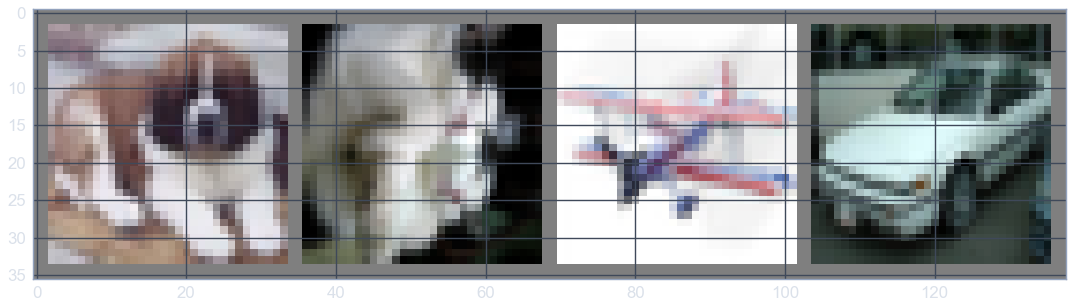

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images


dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
' '.join(classes[label] for label in labels)

## 2. Define a Convolution Neural Network

Copy the neural network from the _Neural Networks_ notebook before and modify it to take 3-channel images

In [13]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


net = Net()
net

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

## 3. Define a Loss function and optimizer

Let’s use a _Classification Cross-Entropy_ loss and _SGD with **momentum**_

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

This is when things start to get interesting. 

We simply have to loop over our data iterator, and feed the inputs to the network and optimize

In [20]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[{}, {}] loss: {:.3f}".format(
                epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0

print("Finished Training")

[1, 2000] loss: 2.233
[1, 4000] loss: 1.902
[1, 6000] loss: 1.715
[1, 8000] loss: 1.607
[1, 10000] loss: 1.539
[1, 12000] loss: 1.479
[2, 2000] loss: 1.405
[2, 4000] loss: 1.394
[2, 6000] loss: 1.354
[2, 8000] loss: 1.302
[2, 10000] loss: 1.279
[2, 12000] loss: 1.282
Finished Training


## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

'cat ship ship plane'

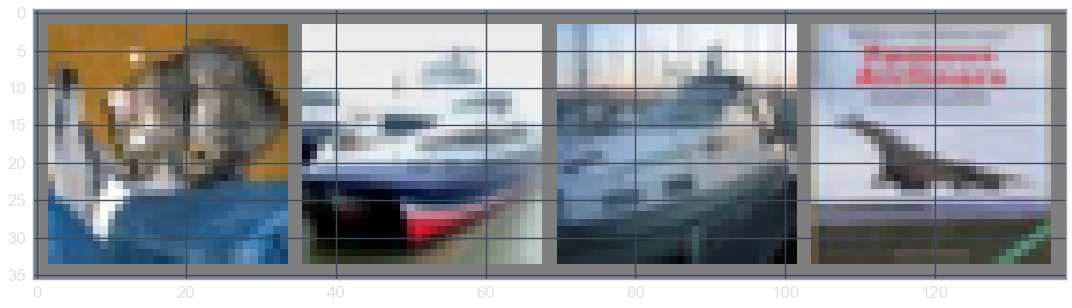

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
' '.join(classes[label] for label in labels)

Okay, now let us see what the neural network thinks these examples above are:

In [22]:
outputs = net(Variable(images))

The outputs are _energies_ for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the _highest energy_:

In [23]:
_, predicted = torch.max(outputs.data, 1)
' '.join(classes[label] for label in predicted)

'ship ship ship ship'

The results seem pretty good

Let us look at how the network performs on the whole dataset

In [24]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

'Accuracy of the network on 10000 test images: {}%'.format(
    correct / total * 100)

'Accuracy of the network on 10000 test images: 56.15%'

That looks **waaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaay** better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [27]:
classes_correct = [0]*10
classes_total = [0]*10
for data in testloader:
    images,labels=data
    outputs=net(Variable(images))
    _,predicted=torch.max(outputs.data,1)
    c=(predicted==labels).squeeze()
    
    for i in range(4):
        label=labels[i]
        classes_correct[label]+=c[i]
        classes_total[label]+=1
        
for i in range(10):
    print("Accuracy of {} : {}%".format(classes[i],int(classes_correct[i]/classes_total[i]*100)))

Accuracy of plane : 63%
Accuracy of car : 76%
Accuracy of bird : 49%
Accuracy of cat : 42%
Accuracy of deer : 38%
Accuracy of dog : 26%
Accuracy of frog : 71%
Accuracy of horse : 63%
Accuracy of ship : 79%
Accuracy of truck : 51%


Okay, so what next?

How do we run these neural networks on the GPU?

# Training on GPU

Just like how you transfer a ```Tensor``` on to the GPU, you transfer the _neural net_ onto the GPU. This will **recursively** go over all modules and convert their parameters and buffers to _CUDA tensors_

```python
net.cuda()
```
Remember that you will have to send the inputs and targets at every step to the GPU too:
```python
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice **MASSIVE** speedup compared to CPU? Because your network is realllly $_{small}$

**Exercise**: Try increasing the _width_ of your network (argument 2 of the first ```nn.Conv2d```, and argument 1 of the second ```nn.Conv2d``` – they need to be the same number), see what kind of speedup you get.